# TNT LLM - Text mining at scale

In this notebook, we propose to review step by step the code proposed in this [documentation article](https://langchain-ai.github.io/langgraph/tutorials/tnt-llm/tnt-llm/#3a-taxonomy-generation-utilities)

The LLM worklfow is composed of several step in order to build a **taxonomy** from a base of unlabeled free-text.
    
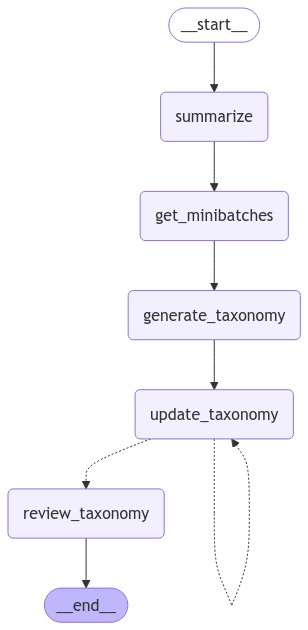


In [2]:
!pip install langchain
!pip install boto3


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached jmespath-1.0.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached s3transfer-0.10.4-py3-none-any.whl.metadata (1.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 7.9 MB/s eta 0:00:00a 0:00:01
Using cached jmespath-1.0.1-py3-none-any.whl (20 kB)
Using cached s3transfer-0.10.4-py3-none-any.whl (83 kB)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import sys
import os 
import nest_asyncio

# Sanity check
print(sys.executable)
nest_asyncio.apply()

#os.environ["OPENAI_API_KEY"] = "sk-"
#os.environ[
#    "AZURE_OPENAI_ENDPOINT"
#] = "https://<your-resource-name>.openai.azure.com/"
#os.environ["OPENAI_API_VERSION"] = "2023-07-01-preview"

import base64
import json
import boto3
import jwt
from botocore.exceptions import ClientError




OPENAI_API_MODEL_NAME = ["gpt-4-32k", "gpt-4", "gpt-4o"]
OPENAI_DEV_KEY = "***************"
OPENAI_API_TYPE = "azure"
OPENAI_API_VERSION = "2023-03-15-preview"
OPENAI_API_BASE = "https://*******.openai.azure.com/"
OPENAI_MODEL_EMBEDDING = "text-embedding-ada-002"



/Users/amorvan/Documents/code_dw/llm_collection/venv/bin/python3.13


In [2]:
from llama_index.llms.openai import OpenAI
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

temperature = 0
model_name="gpt-4o"
llm = AzureOpenAI(
        engine=model_name,
        model=model_name,
        api_key=OPENAI_DEV_KEY,
        azure_endpoint=OPENAI_API_BASE,
        api_version=OPENAI_API_VERSION,
        temperature=temperature,
    )

In [3]:
llm.complete("Hello")

CompletionResponse(text='Hello! How can I assist you today?', additional_kwargs={}, raw=ChatCompletion(id='chatcmpl-Ao62PunWHq4VlkEiH4YIkCjTtmxyw', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1736502973, model='gpt-4', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=9, prompt_tokens=8, total_tokens=17, completion_tokens_details=None, prompt_tokens_details=None)), logprobs=None, delta=None)

In [4]:
import os, re
from pydantic import BaseModel, Field
from llama_index.core.workflow import (
    Workflow,
    step,
    Event,
    Context,
    StartEvent,
    StopEvent
)
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.core import ChatPromptTemplate
from llama_index.llms.openai import OpenAI
from llama_index.core import SimpleDirectoryReader
from llama_index.core import (
    SimpleDirectoryReader,
    load_index_from_storage,
    VectorStoreIndex,
    StorageContext,
)
from llama_index.core.node_parser import SentenceSplitter
from llama_index.retrievers.bm25 import BM25Retriever
import Stemmer
from llama_index.core import VectorStoreIndex, get_response_synthesizer
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import LLMRerank
from llama_index.core.evaluation import FaithfulnessEvaluator

### How to do efficiently a map reduce with LLamaIndex ? 

1 - The Workflow is a subworkflow with only 1 update operation

The recursion pattern would be 

- `S_n` is the current taxonomy at step N
- I have the set of documents `D_n`
- I map the documents into summaries
- The reduce is the transformation of summaries into a step taxonomy `t_n`

 The taxonomy update could be done outside of the workflow `S_n+1 = f(S_n, t_n)`





## Part 1 - Build your first (empty) MapReduce Workflow

You need : 
- a step that emits the tasks **map_dataset**
- A step that maps a given record **map_fn**
- A step that reduces the received MappedResult : **reduce**


Useful function 
- `ctx.send_event( ev )`
- `ctx.collect_events( ev, ExpectEventtList )`
- `ctx.set(VAR_NAME, value)` and `value = await ctx.get(VAR_NAME)`




In [5]:
class MapEvent(Event):
    text: str

class SummaryEvent(Event):
    summary: str


class DummyBatchTaxnomyWorkflow(Workflow):

    @step
    async def map_dataset(self, ctx: Context, ev: StartEvent) -> MapEvent:
        batch_size = 10
        _ = await ctx.set("batch_size", batch_size)
        for _ in range(batch_size):
            ctx.send_event(MapEvent(text="coucou"))

    @step
    async def map_fn(self, ev: MapEvent) -> SummaryEvent:
        return SummaryEvent(summary="Coucou")

    @step
    async def reduce(self, ctx: Context, ev: SummaryEvent) -> StopEvent:
        batch_size = await ctx.get("batch_size")
        result = ctx.collect_events(ev, [SummaryEvent] * batch_size)
        if result is None:
            return None
        return StopEvent(result="""<cluster_table>
              <cluster>
                <id>1</id>
                <name>Product Quality and Preference</name>
                <description>Focuses on the quality of pet food and specific preferences of pets regarding the product.</description>
              </cluster>
              <cluster>
                <id>2</id>
                <name>Product Mislabeling Issues</name>
                <description>Addresses discrepancies in product labeling, including size and type mismatches, leading to customer confusion.</description>
              </cluster>
            </cluster_table>"""
            )



        


In [6]:
from llama_index.utils.workflow import draw_all_possible_flows

draw_all_possible_flows(DummyBatchTaxnomyWorkflow, filename="batch_workflow.html")

<class 'NoneType'>
<class '__main__.MapEvent'>
<class '__main__.SummaryEvent'>
<class 'llama_index.core.workflow.events.StopEvent'>
batch_workflow.html


In [7]:
w = DummyBatchTaxnomyWorkflow()
r = await w.run(message="ok")
r

'<cluster_table>\n              <cluster>\n                <id>1</id>\n                <name>Product Quality and Preference</name>\n                <description>Focuses on the quality of pet food and specific preferences of pets regarding the product.</description>\n              </cluster>\n              <cluster>\n                <id>2</id>\n                <name>Product Mislabeling Issues</name>\n                <description>Addresses discrepancies in product labeling, including size and type mismatches, leading to customer confusion.</description>\n              </cluster>\n            </cluster_table>'

## Part 2 - Adapt the workflow for the use case

todo : 
- Handle the batch size dynamically
- Adapt the input to be a list of text
- Load the prompt templates
- Parse the result







In [88]:
# Prompts were extracted from  hub.pull("wfh/tnt-llm-summary-generation")

SUMMARIZATION_PROMPT_SYSTEM = """
    # Instruction
    
    ## Context
    - **Goal**: You are tasked with summarizing the input text for the given use case. The summary will represent the input data for clustering in the next step.
    - **Data**: Your input data is a conversation history between a User and an AI agent.
    
    # Data
    <data>
    {content}
    </data>
    """

SUMMARIZATION_PROMPT_USER = """
    # Questions
    ## Q1. Summarize the input text in 20 words or less for the use case.
    Write the summary between <summary> </summary> tags.
    
    Tips:
    - The summary should contain the relevant information for the use case in as much detail as possible.
    - Be concise and clear. Do not add phrases like "This is the summary of the data ..." or "Summarized text: ...".
    - Similarly, do not reference the user ('the user asked XYZ') unless it's absolutely relevant.
    - Within {summary_length} words, include as much relevant information as possible.
    - Do not include any line breaks in the summary.
    - Provide your answer in **English** only.
    
    ## Q2. Explain how you wrote the summary in {explanation_length} words or less.
    
    ## Provide your answers between the tags <summary>your answer to Q1</summary>, <explanation>your answer to Q2</explanation>
    
    # Output
    """


tnt_template_msgs = [
    ChatMessage(
        role=MessageRole.SYSTEM,
        content=SUMMARIZATION_PROMPT_SYSTEM,
    ),
    ChatMessage(role=MessageRole.USER, content=SUMMARIZATION_PROMPT_USER),
]

tnt_template = ChatPromptTemplate.from_messages(tnt_template_msgs)
tnt_template

ChatPromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=['content', 'summary_length', 'explanation_length'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, message_templates=[ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='\n    # Instruction\n    \n    ## Context\n    - **Goal**: You are tasked with summarizing the input text for the given use case. The summary will represent the input data for clustering in the next step.\n    - **Data**: Your input data is a conversation history between a User and an AI agent.\n    \n    # Data\n    <data>\n    {content}\n    </data>\n    ', additional_kwargs={}), ChatMessage(role=<MessageRole.USER: 'user'>, content='\n    # Questions\n    ## Q1. Summarize the input text in 20 words or less for the use case.\n    Write the summary between <summary> </summary> tags.\n    \n    Tips:\n    - The summary should contain the relevant information for the use case in as much det

In [98]:
tnt_prompt = tnt_template.format_messages(
    summary_length=20, explanation_length=30, content="I really did not like the color of product that was sent to me, red is ugly"
)
result = llm.chat(tnt_prompt)
result.message.content

ChatResponse(message=ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, content="<summary>User dislikes the red color of the product received, describing it as ugly.</summary>  \n<explanation>I focused on the user's sentiment about the product color, ensuring clarity and conciseness while capturing the main issue expressed.</explanation>", additional_kwargs={}), raw=ChatCompletion(id='chatcmpl-AhGddCYoTQtIDKlqHM5ItUohKC4er', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="<summary>User dislikes the red color of the product received, describing it as ugly.</summary>  \n<explanation>I focused on the user's sentiment about the product color, ensuring clarity and conciseness while capturing the main issue expressed.</explanation>", refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1734875425, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier=None, system_fingerprint='fp_0

In [107]:
def parse_summary(xml_string: str) -> dict:
    summary_pattern = r"<summary>(.*?)</summary>"
    explanation_pattern = r"<explanation>(.*?)</explanation>"

    summary_match = re.search(summary_pattern, xml_string, re.DOTALL)
    explanation_match = re.search(explanation_pattern, xml_string, re.DOTALL)

    summary = summary_match.group(1).strip() if summary_match else ""
    explanation = explanation_match.group(1).strip() if explanation_match else ""

    return {"summary": summary, "explanation": explanation}


parse_summary(result.message.content)

{'summary': 'User dislikes the red color of the product received, describing it as ugly.',
 'explanation': "I focused on the user's sentiment about the product color, ensuring clarity and conciseness while capturing the main issue expressed."}

# Prompts were extracted from  hub.pull("wfh/tnt-llm-taxonomy-generation")
```python
taxonomy_generation_prompt = hub.pull("wfh/tnt-llm-taxonomy-generation").partial(
    use_case="Generate the taxonomy that can be used to label the user intent in the conversation.",
)
messages = taxonomy_generation_prompt.invoke({
    "cluster_description_length": 20, 
    "cluster_name_length": 10, 
    "data_xml": "", 
    "explanation_length": 20, 
    "max_num_clusters": 5}).messages


print(messages[0].content)
print("*" * 20 + "\n")
print(messages[1].content)
```

In [115]:
TAXO_SYSTEM_PROMPT = """
    # Instruction
    ## Context
    - **Goal**: Your goal is to cluster the input data into meaningful categories for the given use case.
    - **Data**: The input data will be a list of human-AI conversation summaries in XML format, including the following elements:
      - **id**: conversation index.
      - **text**: conversation summary.
    - **Use case**: Generate the taxonomy that can be used to label the user intent in the conversation.
    ## Requirements
    ### Format
    - Output clusters in **XML format** with each cluster as a `<cluster>` element, containing the following sub-elements:
      - **id**: category number starting from 1 in an incremental manner.
      - **name**: category name should be **within {cluster_name_length} words**. It can be either verb phrase or noun phrase, whichever is more appropriate.
      - **description**: category description should be **within {cluster_description_length} words**.
    Here is an example of your output:
    ```xml
    <clusters>
      <cluster>
        <id>category id</id>
        <name>category name</name>
        <description>category description</description>
      </cluster>
    </clusters>
    ```
    - Total number of categories should be **no more than {nb_categories}**.
    - Output should be in **English** only.
    ### Quality
    - **No overlap or contradiction** among the categories.
    - **Name** is a concise and clear label for the category. Use only phrases that are specific to each category and avoid those that are common to all categories.
    - **Description** differentiates one category from another.
    - **Name** and **description** can **accurately** and **consistently** classify new data points **without ambiguity**.
    - **Name** and **description** are *consistent with each other*.
     Output clusters match the data as closely as possible, without missing important categories or adding unnecessary ones.
    - Output clusters should strive to be orthogonal, providing solid coverage of the target domain.
    - Output clusters serve the given use case well.
    - Output clusters should be specific and meaningful. - - Do not invent categories that are not in the data.
    
    
    # Data
    <conversations>
    {content}
    </conversations>
    """

TAXO_USER_PROMPT = """
    # Questions
    ## Q1. Please generate a cluster table from the input data that meets the requirements.
    Tips
    - The cluster table should be a **flat list** of **mutually exclusive** categories. Sort them based on their semantic relatedness.
    - Though you should aim for {nb_categories} categories, you can have *fewer than {nb_categories} categories* in the cluster table;  but **do not exceed the limit.** 
    - Be **specific** about each category. **Do not include vague categories** such as "Other", "General", "Unclear", "Miscellaneous" or "Undefined" in the cluster table.
    - You can ignore low quality or ambiguous data points.
    ## Q2. Why did you cluster the data the way you did? Explain your reasoning **within {explanation_length} words**.
    ## Provide your answers between the tags: <cluster_table>your generated cluster table with no more than {nb_categories} categories</cluster_table>, <explanation>explanation of your reasoning process within 20 words</explanation>.
    # Output
    """

"""
content
nb_categories
cluster_name_length
cluster_description_length
explanation_length
"""



'\ncontent\nnb_categories\ncluster_name_length\ncluster_description_length\nexplanation_length\n'

In [144]:
tnt_taxonomy_template_msgs = [
    ChatMessage(
        role=MessageRole.SYSTEM,
        content=TAXO_SYSTEM_PROMPT,
    ),
    ChatMessage(role=MessageRole.USER, content=TAXO_USER_PROMPT),
]

tnt_taxo_template = ChatPromptTemplate.from_messages(tnt_taxonomy_template_msgs)
tnt_taxo_template

ChatPromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=['cluster_name_length', 'cluster_description_length', 'nb_categories', 'content', 'nb_categories', 'nb_categories', 'explanation_length', 'nb_categories'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, message_templates=[ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='\n    # Instruction\n    ## Context\n    - **Goal**: Your goal is to cluster the input data into meaningful categories for the given use case.\n    - **Data**: The input data will be a list of human-AI conversation summaries in XML format, including the following elements:\n      - **id**: conversation index.\n      - **text**: conversation summary.\n    - **Use case**: Generate the taxonomy that can be used to label the user intent in the conversation.\n    ## Requirements\n    ### Format\n    - Output clusters in **XML format** with each cluster as a `<cluster>` element, containing the

In [186]:
from typing import Dict, List, Any


def parse_taxa(output_text: str) -> Dict:
    """Extract the taxonomy from the generated output."""
    cluster_matches = re.findall(
        r"\s*<id>(.*?)</id>\s*<name>(.*?)</name>\s*<description>(.*?)</description>\s*",
        output_text,
        re.DOTALL,
    )
    clusters = [
        {"id": id.strip(), "name": name.strip(), "description": description.strip()}
        for id, name, description in cluster_matches
    ]
    # We don't parse the explanation since it isn't used downstream
    return {"clusters": clusters}



def format_docs(docs: List[str]) -> str:
    xml_table = "<conversations>\n"
    for i, doc in enumerate(docs):
        xml_table += f'<conv_summ id={i}>{doc}</conv_summ>\n'
    xml_table += "</conversations>"
    return xml_table



In [192]:
class MapEvent(Event):
    text: str


class SummaryEvent(Event):
    summary: str


class BatchTaxnomyWorkflow(Workflow):

    @step
    async def map_dataset(self, ctx: Context, ev: StartEvent) -> MapEvent:
        documents = ev["documents"]
        batch_size = len(documents)
        _ = await ctx.set("batch_size", batch_size)
        for doc in documents:
            ctx.send_event(MapEvent(text=doc))

    @step
    async def map_fn(self, ev: MapEvent) -> SummaryEvent:
        tnt_prompt = tnt_template.format_messages(
            summary_length=20, explanation_length=30, content=ev.text
        )
        result = llm.chat(tnt_prompt)
        return SummaryEvent(summary=result.message.content)

    @step
    async def reduce_fn(self, ctx: Context, ev: SummaryEvent) -> StopEvent:
        batch_size = await ctx.get("batch_size")
        results = ctx.collect_events(ev, [SummaryEvent] * batch_size)
        if results is None:
            return None
        summary_xml = format_docs([x.summary for x in results])

        prompt = tnt_taxo_template.format_messages(
            content=summary_xml,
            nb_categories=5,
            cluster_name_length=15,
            cluster_description_length=30,
            explanation_length=30,
        )
        result = llm.chat(prompt)
        rez = parse_taxa(result.message.content)
        taxo = format_taxonomy(rez["clusters"])
        return StopEvent(result=taxo)



In [193]:
import pandas as pd
df = pd.read_csv("/Users/amorvan/Documents/code_dw/llm_collection/amazon-fine-food-reviews/Reviews.csv")
rows = list(df.itertuples())
rows[0]

Pandas(Index=0, Id=1, ProductId='B001E4KFG0', UserId='A3SGXH7AUHU8GW', ProfileName='delmartian', HelpfulnessNumerator=1, HelpfulnessDenominator=1, Score=5, Time=1303862400, Summary='Good Quality Dog Food', Text='I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.')

In [194]:
w = BatchTaxnomyWorkflow()
r = await w.run(documents=[x.Text for x in rows[:2]])
r

'<cluster_table>\n  <cluster>\n    <id>1</id>\n    <name>Praise for Dog Food Quality</name>\n    <description>User appreciates the quality and appeal of a specific dog food brand.</description>\n  </cluster>\n  <cluster>\n    <id>2</id>\n    <name>Product Discrepancy Issues</name>\n    <description>User reports issues with received product size and salt content, questioning vendor accuracy.</description>\n  </cluster>\n</cluster_table>'

In [195]:
print(r)

<cluster_table>
  <cluster>
    <id>1</id>
    <name>Praise for Dog Food Quality</name>
    <description>User appreciates the quality and appeal of a specific dog food brand.</description>
  </cluster>
  <cluster>
    <id>2</id>
    <name>Product Discrepancy Issues</name>
    <description>User reports issues with received product size and salt content, questioning vendor accuracy.</description>
  </cluster>
</cluster_table>


## Part 3 - The new workflow will host the handling of the batch processing

todo : 
- Handle the rest of the logic : process batches, update iteratively the taxonomy
- Use the workflow defined before to handle the batches








In [183]:
taxonomy_update_prompt = hub.pull("wfh/tnt-llm-taxonomy-update")
rez = taxonomy_update_prompt.messages

print(rez[0].prompt.template)
print("*"*20 + "\n")
print(rez[1].prompt.template)

/Users/amorvan/Documents/code_dw/llm_collection/venv/lib/python3.13/site-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


# Instruction
## Context
- **Goal**: You goal is to review the given reference table based on the input data for the specified use case, then update the reference table if needed.
  - You will be given a reference cluster table, which is built on existing data. The reference table will be used to classify new data points.
  - You will compare the input data with the reference table, output a rating score of the quality of the reference table, suggest potential edits, and update the reference table if needed.
- **Reference cluster table**: The input cluster table is in XML format with each cluster as a `<cluster>` element, containing the following sub-elements:
  - **id**: category index.
  - **name**: category name.
  - **description**: category description used to classify data points.
- **Data**: The input data will be a list of human-AI conversation summaries in XML format, including the following elements:
  - **id**: conversation index.
  - **text**: conversation summary.
- **Use 

In [211]:
TAXONOMY_UPDATE_SYSTEM = """
    # Instruction
    ## Context
    - **Goal**: You goal is to review the given reference table based on the input data for the specified use case, then update the reference table if needed.
      - You will be given a reference cluster table, which is built on existing data. The reference table will be used to classify new data points.
      - You will compare the input data with the reference table, output a rating score of the quality of the reference table, suggest potential edits, and update the reference table if needed.
    - **Reference cluster table**: The input cluster table is in XML format with each cluster as a `<cluster>` element, containing the following sub-elements:
      - **id**: category index.
      - **name**: category name.
      - **description**: category description used to classify data points.
    - **Data**: The input data will be a list of human-AI conversation summaries in XML format, including the following elements:
      - **id**: conversation index.
      - **text**: conversation summary.
    - **Use case**: {use_case}
    
    ## Requirements
    ### Format
    - Output clusters in **XML format** with each cluster as a `<cluster>` element, containing the following sub-elements:
      - **id**: category number starting from 1 in an incremental manner.
      - **name**: category name should be **within {cluster_name_length} words**. It can be either verb phrase or noun phrase, whichever is more appropriate.
      - **description**: category description should be **within {cluster_description_length} words**.
    
    Here is an example of your output:
    ```xml
    <clusters>
      <cluster>
        <id>category id</id>
        <name>category name</name>
        <description>category description</description>
      </cluster>
    </clusters>
    ```
    - Total number of categories should be **no more than {max_num_clusters}**.
    - Output should be in **English** only.
    
    ### Quality
    - **No overlap or contradiction** among the categories.
    - **Name** is a concise and clear label for the category. Use only phrases that are specific to each category and avoid those that are common to all categories.
    - **Description** differentiates one category from another.
    - **Name** and **description** can **accurately** and **consistently** classify new data points **without ambiguity**.
    - **Name** and **description** are *consistent with each other*.
    - Output clusters match the data as closely as possible, without missing important categories or adding unnecessary ones.
    - Output clusters should strive to be orthogonal, providing solid coverage of the target domain.
    - Output clusters serve the given use case well.
    - Output clusters should be specific and meaningful. Do not invent categories that are not in the data.
    
    # Reference cluster table
    <reference_table>
    {cluster_table_xml}
    </reference_table>
    
    # Data
    <conversations>
    {data_xml}
    </conversations>
   """

TAXONOMY_UPDATE_USER = """
    # Questions
    ## Q1: Review the given reference table and the input data and provide a rating score of the reference table. The rating score should be an integer between 0 and 100, higher rating score means better quality. You should consider the following factors when rating the reference cluster table:
    - **Intrinsic quality**:
      - 1) if the cluster table meets the *Requirements* section, with clear and consistent category names and descriptions, and no overlap or contradiction among the categories;
      - 2) if the categories in the cluster table are relevant to the the given use case;
      - 3) if the cluster table includes any vague categories such as "Other", "General", "Unclear", "Miscellaneous" or "Undefined".
    - **Extrinsic quality**:
      - 1) if the cluster table can accurately and consistently classify the input data without ambiguity;
      - 2) if there are missing categories in the cluster table but appear in the input data;
      - 3) if there are unnecessary categories in the cluster table that do not appear in the input data.
    ## Q2: Explain your rating score in Q1 **within {explanation_length} words**.
    ## Q3: Based on your review, decide if you need to edit the reference table to improve its quality. If yes, suggest potential edits **within {suggestion_length} words**. If no, please output the original reference table.
    
    Tips:
    - You can edit the category name, description, or remove a category. You can also merge or add new categories if needed. Your edits should meet the *Requirements* section.
    - The cluster table should be a **flat list** of **mutually exclusive** categories. Sort them based on their semantic relatedness.
    - You can have *fewer than {max_num_clusters} categories* in the cluster table, but **do not exceed the limit.**
    - Be **specific** about each category. **Do not include vague categories** such as "Other", "General", "Unclear", "Miscellaneous" or "Undefined" in the cluster table.
    - You can ignore low quality or ambiguous data points.
    ## Q4: If you decide to edit the reference table, please provide your updated reference table. If you decide not to edit the reference table, please output the original reference table.
    ## Provide your answers between the following tags:
    <rating_score>integer between 0 and 100</rating_score>
    <explanation>explanation of your rating score within {explanation_length} words</explanation>
    <suggestions>suggested edits within {suggestion_length} words, or "N/A" if no edits needed</suggestions>
    <updated_table>
    your updated cluster table in XML format if you decided to edit the reference table, or the original reference table if no edits made
    </updated_table>
    # Output
    """


In [212]:
tnt_taxonomy_update_template_msgs = [
    ChatMessage(
        role=MessageRole.SYSTEM,
        content=TAXONOMY_UPDATE_SYSTEM,
    ),
    ChatMessage(role=MessageRole.USER, content=TAXONOMY_UPDATE_USER),
]

tnt_taxo_update_template = ChatPromptTemplate.from_messages(tnt_taxonomy_update_template_msgs)
tnt_taxo_update_template



ChatPromptTemplate(metadata={'prompt_type': <PromptType.CUSTOM: 'custom'>}, template_vars=['use_case', 'cluster_name_length', 'cluster_description_length', 'max_num_clusters', 'cluster_table_xml', 'data_xml', 'explanation_length', 'suggestion_length', 'max_num_clusters', 'explanation_length', 'suggestion_length'], kwargs={}, output_parser=None, template_var_mappings=None, function_mappings=None, message_templates=[ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='\n    # Instruction\n    ## Context\n    - **Goal**: You goal is to review the given reference table based on the input data for the specified use case, then update the reference table if needed.\n      - You will be given a reference cluster table, which is built on existing data. The reference table will be used to classify new data points.\n      - You will compare the input data with the reference table, output a rating score of the quality of the reference table, suggest potential edits, and update the reference t

In [213]:
def format_taxonomy(clusters):
    xml = "<cluster_table>\n"
    for label in clusters:
        xml += "  <cluster>\n"
        xml += f'    <id>{label["id"]}</id>\n'
        xml += f'    <name>{label["name"]}</name>\n'
        xml += f'    <description>{label["description"]}</description>\n'
        xml += "  </cluster>\n"
    xml += "</cluster_table>"
    return xml

In [214]:

class BatchUpdateTaxnomyWorkflow(Workflow):

    @step
    async def map_dataset(self, ctx: Context, ev: StartEvent) -> MapEvent:
        documents = ev["documents"]
        taxonomy = ev.get("taxonomy")
        batch_size = len(documents)
        _ = await ctx.set("batch_size", batch_size)
        _ = await ctx.set("taxonomy", taxonomy)
        for doc in documents:
            ctx.send_event(MapEvent(text=doc))

    @step
    async def map_fn(self, ev: MapEvent) -> SummaryEvent:
        tnt_prompt = tnt_template.format_messages(
            summary_length=20, explanation_length=30, content=ev.text
        )
        result = llm.chat(tnt_prompt)
        return SummaryEvent(summary=result.message.content)

    @step
    async def reduce_fn(self, ctx: Context, ev: SummaryEvent) -> StopEvent:
        batch_size = await ctx.get("batch_size")
        taxonomy = await ctx.get("taxonomy")
        results = ctx.collect_events(ev, [SummaryEvent] * batch_size)
        if results is None:
            return None
        summary_xml = format_docs([x.summary for x in results])

        if taxonomy is None:
            prompt = tnt_taxo_template.format_messages(
                content=summary_xml,
                nb_categories=15,
                cluster_name_length=15,
                cluster_description_length=30,
                explanation_length=30,
            )
        else:
            #taxonomy_xml = format_taxonomy(taxonomy)
            prompt = tnt_taxo_template.format_messages(
                data_xml=summary_xml,
                cluster_table_xml=taxonomy,
                nb_categories=15,
                cluster_name_length=15,
                cluster_description_length=30,
                explanation_length=30,
            )
            
        result = llm.chat(prompt)
        rez = parse_taxa(result.message.content)
        taxo = format_taxonomy(rez["clusters"])
        return StopEvent(result=taxo)


In [215]:
w = BatchUpdateTaxnomyWorkflow()

#r = await w.run(documents=[x.Text for x in rows[6:8]], taxonomy=r)

In [209]:
import pandas as pd
df = pd.read_csv("/Users/amorvan/Documents/code_dw/llm_collection/amazon-fine-food-reviews/Reviews.csv")
rows = list(df.sample(frac=0.02).itertuples())
len(rows)

11369

In [210]:
first_taxo = await w.run(documents=[x.Text for x in rows[:200]])
print(first_taxo)

<cluster_table>
  <cluster>
    <id>1</id>
    <name>Product Quality and Satisfaction</name>
    <description>Reviews focusing on the quality, taste, and overall satisfaction with various food and beverage products.</description>
  </cluster>
  <cluster>
    <id>2</id>
    <name>Pet Food and Treats</name>
    <description>Conversations about the quality, preferences, and experiences related to pet food and treats for dogs and cats.</description>
  </cluster>
  <cluster>
    <id>3</id>
    <name>Health and Dietary Preferences</name>
    <description>Discussions on health benefits, dietary choices, and preferences for low-calorie or organic food products.</description>
  </cluster>
  <cluster>
    <id>4</id>
    <name>Shopping Experience and Recommendations</name>
    <description>Insights on shopping experiences, product recommendations, and comparisons between different brands and retailers.</description>
  </cluster>
  <cluster>
    <id>5</id>
    <name>Cooking and Preparation Tips</n

In [216]:
all_taxos = [first_taxo]
for i in range(round(len(rows) / 200)):
    batch = rows[i*200: (i+1)*200]
    new_taxo = await w.run(documents=[x.Text for x in rows[:200]], taxonomy=all_taxos[-1])
    all_taxos.append(new_taxo)
    if i > 5:
        break

In [217]:
all_taxos

['<cluster_table>\n  <cluster>\n    <id>1</id>\n    <name>Product Quality and Satisfaction</name>\n    <description>Reviews focusing on the quality, taste, and overall satisfaction with various food and beverage products.</description>\n  </cluster>\n  <cluster>\n    <id>2</id>\n    <name>Pet Food and Treats</name>\n    <description>Conversations about the quality, preferences, and experiences related to pet food and treats for dogs and cats.</description>\n  </cluster>\n  <cluster>\n    <id>3</id>\n    <name>Health and Dietary Preferences</name>\n    <description>Discussions on health benefits, dietary choices, and preferences for low-calorie or organic food products.</description>\n  </cluster>\n  <cluster>\n    <id>4</id>\n    <name>Shopping Experience and Recommendations</name>\n    <description>Insights on shopping experiences, product recommendations, and comparisons between different brands and retailers.</description>\n  </cluster>\n  <cluster>\n    <id>5</id>\n    <name>Cookin

In [218]:
print(all_taxos[-1])

<cluster_table>
  <cluster>
    <id>1</id>
    <name>Requesting Technical Support</name>
    <description>Users seeking help with technical issues or troubleshooting problems related to products or services.</description>
  </cluster>
  <cluster>
    <id>2</id>
    <name>Inquiring About Product Features</name>
    <description>Users asking for detailed information about specific features or functionalities of a product.</description>
  </cluster>
  <cluster>
    <id>3</id>
    <name>Seeking Pricing Information</name>
    <description>Users looking for details regarding pricing, discounts, or payment options for products or services.</description>
  </cluster>
  <cluster>
    <id>4</id>
    <name>Requesting Order Status</name>
    <description>Users inquiring about the status of their orders, including shipping and delivery updates.</description>
  </cluster>
  <cluster>
    <id>5</id>
    <name>Providing Feedback or Reviews</name>
    <description>Users sharing their experiences, opini

In [219]:
print(all_taxos[2])

<cluster_table>
  <cluster>
    <id>1</id>
    <name>Requesting Information</name>
    <description>Users seek specific details or clarification on a topic or service.</description>
  </cluster>
  <cluster>
    <id>2</id>
    <name>Technical Support Queries</name>
    <description>Users ask for help with technical issues or troubleshooting problems.</description>
  </cluster>
  <cluster>
    <id>3</id>
    <name>Product Recommendations</name>
    <description>Users request suggestions for products based on their needs or preferences.</description>
  </cluster>
  <cluster>
    <id>4</id>
    <name>Feedback and Reviews</name>
    <description>Users provide opinions or feedback about products or services they have used.</description>
  </cluster>
  <cluster>
    <id>5</id>
    <name>Account Management</name>
    <description>Users inquire about managing their accounts, including updates and settings.</description>
  </cluster>
  <cluster>
    <id>6</id>
    <name>Service Availability</nam